In [1]:
# Reference: https://www.kaggle.com/code/kanncaa1/pytorch-tutorial-for-deep-learning-lovers



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import torch
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 

print("Used Device for Training: ", dev)

Used Device for Training:  cpu


# Import Libraries

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Data Loading

In [4]:
train = pd.read_csv("../input/digit-recognizer/train.csv", dtype = np.float32)

# Data Cleaning 

In [5]:
labels_numpy = train.label.values
features_numpy = train.drop("label", axis=1)
features_numpy = features_numpy.values/255

In [6]:
features_train, features_test, labels_train, labels_test = train_test_split(features_numpy,
                                                                             labels_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

# Convert Numpy to PyTorch Tensor

In [7]:
featuresTrain = torch.from_numpy(features_train)
LabelsTrain = torch.from_numpy(labels_train).type(torch.LongTensor) # data type is long

featuresTest = torch.from_numpy(features_test)
LabelsTest = torch.from_numpy(labels_test).type(torch.LongTensor) # data type is long

# Dataloader

In [8]:
from torch.utils.data import Dataset, DataLoader

class DigitDataset(Dataset):
    def __init__(self, X, labels):
        self.X = X
        self.labels = labels

    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        return self.X[idx], self.labels[idx]

In [9]:
data_training = DigitDataset(featuresTrain, LabelsTrain)
data_testing = DigitDataset(featuresTest, LabelsTest)

In [10]:
image, label = data_training[1]

In [11]:
image.shape, label.shape

(torch.Size([784]), torch.Size([]))

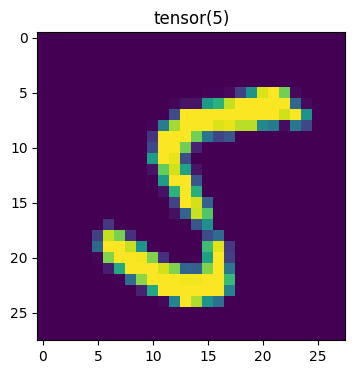

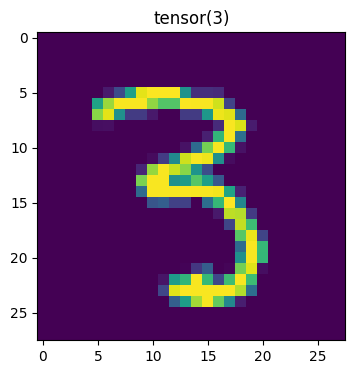

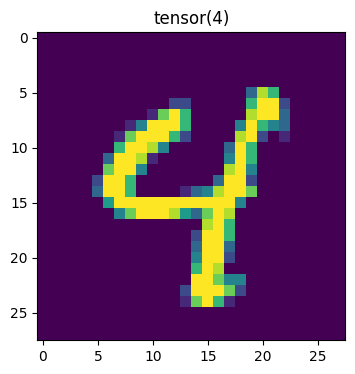

In [12]:
for i in range(1, 4):
    image, label = data_training[i]
    plt.figure(figsize=(6, 4))
    plt.imshow(torch.reshape(image, (28, 28)))
    plt.title(str(label))
    plt.show()

In [13]:
num_epochs = int(5)
batch_size = 100

In [14]:
train_loader = DataLoader(data_training, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(data_testing, batch_size = batch_size, shuffle = False)

In [15]:
for images, labels in train_loader: 
    break

In [16]:
print(train_loader.dataset.labels.shape)
print(train_loader.dataset.X.shape)

torch.Size([33600])
torch.Size([33600, 784])


In [17]:
images.shape, labels.shape

(torch.Size([100, 784]), torch.Size([100]))

In [18]:
print("number of samples:", len(train_loader.dataset.X))
print("batch size:", batch_size)
print("Number of batches:", len(train_loader))

number of samples: 33600
batch size: 100
Number of batches: 336


In [19]:
# Create ANN Model
class ANNModel(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(ANNModel, self).__init__()
        
       
        self.fc1 = nn.Linear(input_dim, 450) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()
        
      
        self.fc2 = nn.Linear(450, 350)
        # Non-linearity 2
        self.tanh2 = nn.Tanh()
        
    
        self.fc3 = nn.Linear(350, 50)
        # Non-linearity 3
        self.elu3 = nn.ELU()
        
   
        self.fc4 = nn.Linear(50, output_dim)  
    
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)
        
        
        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.elu3(out)
        
        # Linear function 4 (readout)
        out = self.fc4(out)
        return out

# instantiate ANN
input_dim = 28*28
output_dim = 10

# Create ANN
model = ANNModel(input_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Model Summary

In [ ]:
pip install torch-summary

In [ ]:
from torchsummary import summary
summary(model = model, input_data = (1, 28*28), col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds"])

In [20]:
# Traning the Model
count = 0
loss_list = []
iteration_list = []


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The Used device: {device}")


# Move the model to the chosen device
model.to(device)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        
        # Define variables
        train = images.view(-1, 28*28)
        labels = labels
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        # Prediction
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader: 
                images = images.to(device)
                labels = labels.to(device)
                
                test = images.view(-1, 28*28)
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(count, loss.data, accuracy))
            
            
print(count)

The Used device: cpu
Iteration: 500  Loss: 0.7421886920928955  Accuracy: 78.94047546386719%
Iteration: 1000  Loss: 0.485736608505249  Accuracy: 87.47618865966797%
Iteration: 1500  Loss: 0.23636053502559662  Accuracy: 89.4047622680664%
1680


In [ ]:



def train_loop(model, train_loader, test_loader, num_epochs): 
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"The Used device: {device}")
    
    # Move the model to the chosen device
    model.to(device)

    for epoch in range(num_epochs):
        
        model.train()
        
        for i, (images, labels) in enumerate(train_loader):

            images = images.to(device)
            labels = labels.to(device)


            # Define variables
            train = images.view(-1, 28*28)
            labels = labels

            # Clear gradients
            optimizer.zero_grad()

            # Forward propagation
            outputs_train = model(train)

            # Calculate softmax and cross entropy loss
            loss = error(outputs, labels)

            # Calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()
            
        acc = (torch.argmax(outputs_train.data, dim=1) == train_loader.dataset.labels).float().mean().item()
        
        
            model.eval()
            with torch.no_grad():
            # Predict test dataset
                for images, labels in test_loader: 
                    images = images.to(device)
                    labels = labels.to(device)

                    test = images.view(-1, 28*28)

                    # Forward propagation
                    outputs_val = model(test)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]

                # Tot
            
            
print(count)

# Evaluation

In [24]:

import numpy as np 
from sklearn.metrics import accuracy_score



y_pred = torch.empty(0, dtype=torch.int64, device=device)

correct = 0 
total = 0 

model.eval()

with torch.no_grad():
    for images, labels in test_loader: 
                images = images.to(device)
                labels = labels.to(device)

                test = images.view(-1, 28*28)

                # predict
                outputs = model(test)

                # Find predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]

                y_pred = torch.cat((y_pred, predicted), dim=0)
                # Total number of labels
                total += len(labels)
                correct += (predicted == labels).sum()
                accuracy = 100 * correct / float(total)







# the classic way 
accuracy = 100 * correct / float(total)    
print(accuracy)





print("Accuracy:", round(accuracy_score(test_loader.dataset.labels, y_pred.cpu()) * 100, 5), "\n")



tensor(90.0595)
Accuracy: 90.05952 



In [64]:
torch.max(outputs.data, 1)

torch.return_types.max(
values=tensor([ 4.4812,  4.7071,  4.5895,  7.1967,  8.1291,  7.7525,  8.1209, 11.2574,
         8.9550, 11.0189,  9.3801, 11.5612,  8.2886,  9.6760,  9.2386, 11.3614,
         9.5506,  8.1629,  6.7305, 11.3075, 10.5814,  5.0486,  5.2546,  9.3020,
        11.4969,  4.9387,  4.9165, 10.0361,  6.2263,  2.9841,  8.6053, 12.5934,
         7.6778,  8.7309,  7.2407,  5.2212, 12.4546,  6.9432,  6.1063, 10.6029,
         5.1480,  6.1836,  9.1759, 10.9687,  6.1119,  8.5468,  6.5148,  4.5450,
        10.8837,  8.2593,  8.4755,  8.4676,  5.6592,  5.2601, 10.2174,  7.6974,
         5.2775,  8.8238,  7.7491,  6.1068, 11.4629, 12.3195, 10.6768, 11.3415,
         7.4052, 10.4825,  5.7693,  9.7890,  8.5859,  4.9128,  6.7623,  7.9783,
         4.8820,  5.0079,  8.1100,  7.3240,  4.8377,  9.5572,  6.7333,  6.8256,
         8.7530,  6.4670,  8.4049,  8.6438,  5.6133,  7.0323,  8.4546,  9.5907,
         8.3660,  5.9010,  5.9110,  5.4693,  8.5247,  7.6682,  4.0199,  4.2503,
         

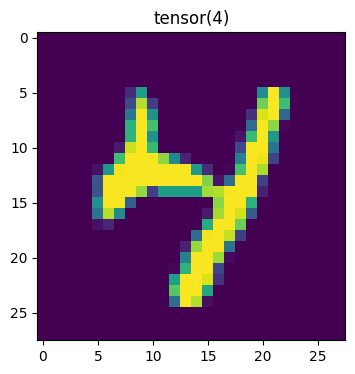

predicted value: torch.return_types.max(
values=tensor([8.6795]),
indices=tensor([4])) label value: tensor(4)


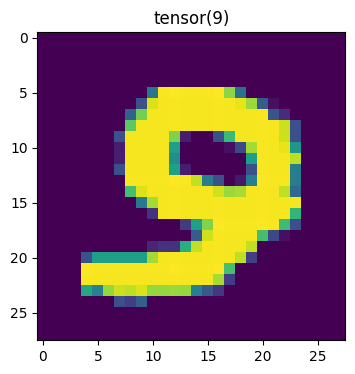

predicted value: torch.return_types.max(
values=tensor([6.6160]),
indices=tensor([0])) label value: tensor(9)


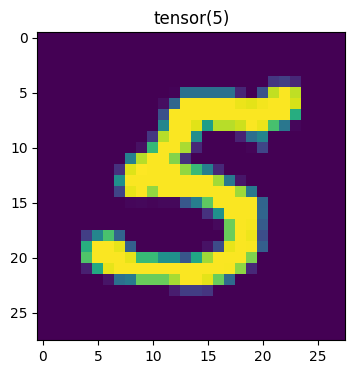

predicted value: torch.return_types.max(
values=tensor([9.7627]),
indices=tensor([5])) label value: tensor(5)


In [92]:
# image, label = data_testing[1]
model.eval()

for i in range(19, 22):
    image, label = data_testing[i]
    plt.figure(figsize=(6, 4))
    plt.imshow(torch.reshape(image, (28, 28)))
    plt.title(str(label))
    plt.show()
    
    test = image.view(-1, 28*28)
    outputs = model(test)
    
    
    predicted = torch.max(outputs.data, 1)
    print("predicted value:", predicted, "label value:", label)
    
   
#     correct = (predicted == label).sum()
#     print(correct)
  
    

# making evaluation method 

Accuracy: 90.39286 

Accuracy: 90.39286 

              precision    recall  f1-score   support

           0   0.936095  0.969363  0.952438       816
           1   0.948663  0.975798  0.962039       909
           2   0.889017  0.908983  0.898890       846
           3   0.921176  0.835646  0.876329       937
           4   0.889782  0.923719  0.906433       839
           5   0.846381  0.816239  0.831037       702
           6   0.895683  0.951592  0.922792       785
           7   0.900000  0.917133  0.908486       893
           8   0.913486  0.859880  0.885873       835
           9   0.883918  0.872315  0.878078       838

    accuracy                       0.903929      8400
   macro avg   0.902420  0.903067  0.902239      8400
weighted avg   0.903860  0.903929  0.903375      8400
 



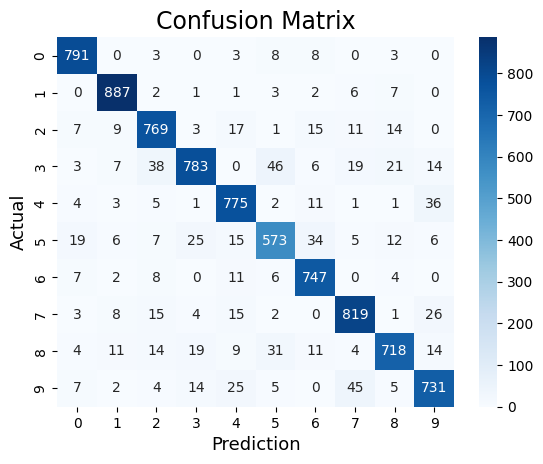

In [43]:
def evaluate(model, test_loader): 
    
    import torch
    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score
    import numpy as np
    from sklearn.metrics import confusion_matrix,classification_report
    import seaborn as sns
    import matplotlib.pyplot as plt 

    # select the device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    y_pred = torch.empty(0, dtype=torch.int64, device=device)
    
    y_pred_2 = torch.empty(0, dtype=torch.int64, device=device)
    
    # set the model to evaluation mode
    model.eval()
    
    
    with torch.no_grad(): 
        for images, labels in test_loader: 
                    images = images.to(device)
                    labels = labels.to(device)

                    # reshape the imput 
                    test = images.view(-1, 28*28)

                    # predict
                    outputs = model(test)

                    # Find predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]
                    
                    predicted_2 = torch.argmax(outputs.data, dim=1)
                    

                    # Concatenate each iteration values
                    y_pred = torch.cat((y_pred, predicted), dim=0)
                    y_pred_2 = torch.cat((y_pred_2, predicted), dim=0)
                    
    # model classes 
    classes = list(map(str, torch.unique(test_loader.dataset.labels).tolist()))
  
    # to find accuracy 
    print("Accuracy:", round(accuracy_score(test_loader.dataset.labels, y_pred.cpu()) * 100, 5), "\n")
    # to find accuracy 
    print("Accuracy:", round(accuracy_score(test_loader.dataset.labels, y_pred_2.cpu()) * 100, 5), "\n")
    
    # to find classification teport
    print(classification_report(test_loader.dataset.labels, y_pred.cpu(), digits=6, target_names=classes), "\n")
    
    # to find confusion matrix 
    cm = confusion_matrix(test_loader.dataset.labels, y_pred.cpu())
    sns.heatmap(cm, annot=True,fmt='g', cmap= 'Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Prediction',fontsize=13)
    plt.ylabel('Actual',fontsize=13)
    plt.title('Confusion Matrix',fontsize=17)
    plt.show()
    
  
    
evaluate(model, test_loader)
